In [1]:
import pandas as pd
import numpy as np
import pickle  # only if needed for something else here

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from src.models.ml_models import RandomForestModel, SVRModel, XGBModel
from sklearn.preprocessing import LabelEncoder

In [2]:
def preprocess_dataframe(df, features, target):
    # 1. Drop rows with missing target values
    df = df.dropna(subset=[target])

    # 2. Handle non-numeric features by encoding them or dropping them
    for col in features:
        if df[col].dtype == 'object':  # If it's a string or non-numeric dtype
            # Check if the column has only a few unique values (suitable for encoding)
            if df[col].nunique() < 20:
                encoder = LabelEncoder()
                df[col] = encoder.fit_transform(df[col].astype(str))
            else:
                # Drop the column if it's not suitable for encoding or too complex
                df = df.drop(columns=[col])

    # 3. Replace invalid numeric values (NaN, inf, -inf)
    df = df.replace([np.inf, -np.inf], np.nan)  # Replace inf/-inf with NaN
    df = df.fillna(0)  # Replace NaN with 0 (or use another imputation strategy)

    # 4. Clip to the range of float32 to avoid overflows
    for col in df.select_dtypes(include=[np.number]).columns:  # Numeric columns only
        df[col] = np.clip(df[col], a_min=np.finfo(np.float32).min, a_max=np.finfo(np.float32).max)

    return df

In [3]:
def train_and_select_features_with_rf(df, target_col, top_n, date_col):
    df = preprocess_dataframe(df, df.columns.difference([target_col, date_col]), target_col)

    # Separate features and target
    X = df.drop(columns=[target_col, date_col])
    y = df[target_col]

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

    # Train Random Forest Model
    rf_prelim = RandomForestModel(n_estimators=50, random_state=42)
    rf_prelim.fit(X_train, y_train)

    # Feature importance extraction
    importances = rf_prelim.feature_importances_
    feature_importances = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    y_pred = rf_prelim.predict(X_test)
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, alpha=0.5, color='blue')  # Plot predictions
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Perfect prediction line
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Predicted vs Actual Values')
    plt.show()

    print(feature_importances.head(top_n))
    return rf_prelim, feature_importances['feature'].head(top_n).tolist(), rf_prelim.score(X_test, y_test)

Train shape: (32636, 57) Test shape: (8160, 57)


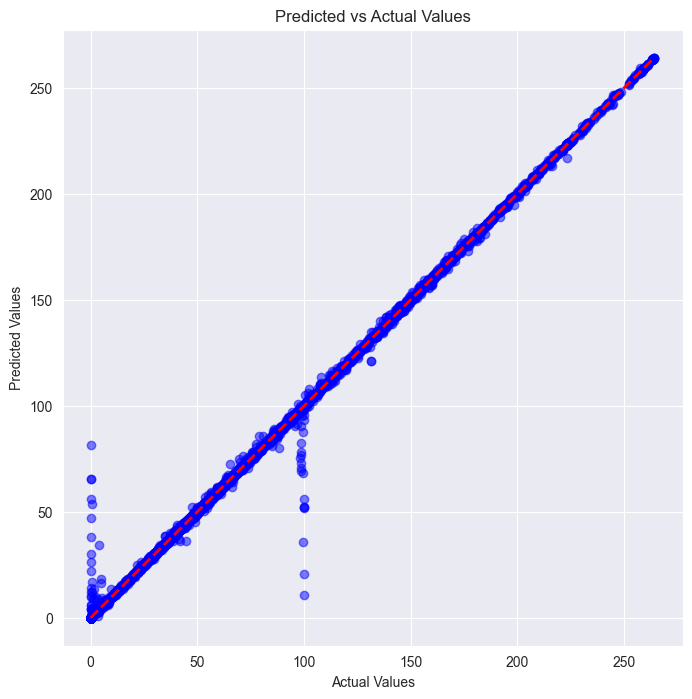

                    feature  importance
33                  Smfeuro    0.916023
27                      Smf    0.070547
51                       ts    0.007079
0                Unnamed: 0    0.002514
15    Gerceklesenithalkomur    0.000596
31                    Dolar    0.000396
14        Gerceklesenakarsu    0.000279
12       Gerceklesenbarajli    0.000265
16        Gerceklesenruzgar    0.000249
32                     Euro    0.000235
25  Gerceklesenuluslararasi    0.000197
26        Gerceklesentoplam    0.000180
6            Maxsatisfiyati    0.000168
13        Gerceklesenlinyit    0.000110
2     Saatlikeslesmemiktari    0.000101

Selected Features after training:
 ['Smfeuro', 'Smf', 'ts', 'Unnamed: 0', 'Gerceklesenithalkomur', 'Dolar', 'Gerceklesenakarsu', 'Gerceklesenbarajli', 'Gerceklesenruzgar', 'Euro', 'Gerceklesenuluslararasi', 'Gerceklesentoplam', 'Maxsatisfiyati', 'Gerceklesenlinyit', 'Saatlikeslesmemiktari']
Scores: 0.9975184079822974


In [4]:
df_full = pd.read_csv("merged_agri_df.csv", parse_dates=["Tarih"])
df_full.dropna()
# Call the training function
model, features, scores = train_and_select_features_with_rf(df_full,
                                                            target_col="Smfdolar",
                                                            top_n=15,
                                                            date_col="Tarih")
print("\nSelected Features after training:\n", features)
print("Scores:", scores)

In [23]:
# Features and Target Column
features = df_full.columns.difference(["Smfdolar", "Tarih"])  # Drop target and date columns
target_col = "Smfdolar"  # Target column
date_col = "Tarih"

df_full = preprocess_dataframe(df_full, df_full.columns.difference([target_col, date_col]), target_col)

# Preprocessing and splitting the data
# Remove target column and date column from features
X = df_full.drop(columns=[target_col, date_col])  # Feature matrix
y = df_full[target_col]  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train shape
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (32636, 57), Test shape: (8160, 57)


In [ ]:
# Import required metrics
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the SVR model
svr_model = SVRModel(kernel='rbf', C=100, epsilon=0.1, name="SupportVectorRegressor")

# Train the SVRModel
svr_model.fit(X_train, y_train)

# Predict values using the test set
y_pred_svr = svr_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred_svr)  # Mean Squared Error
r2 = r2_score(y_test, y_pred_svr)  # R² (coefficient of determination)

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


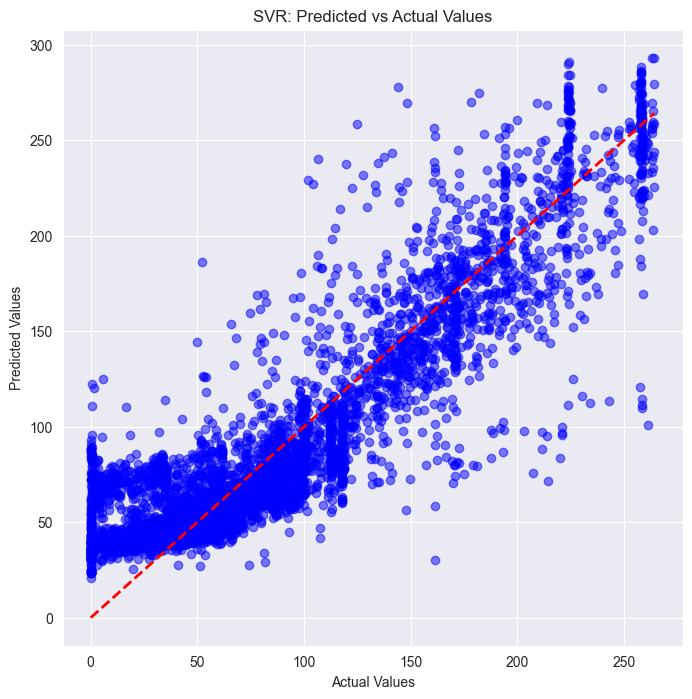

In [24]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_svr, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('SVR: Predicted vs Actual Values')
plt.show()


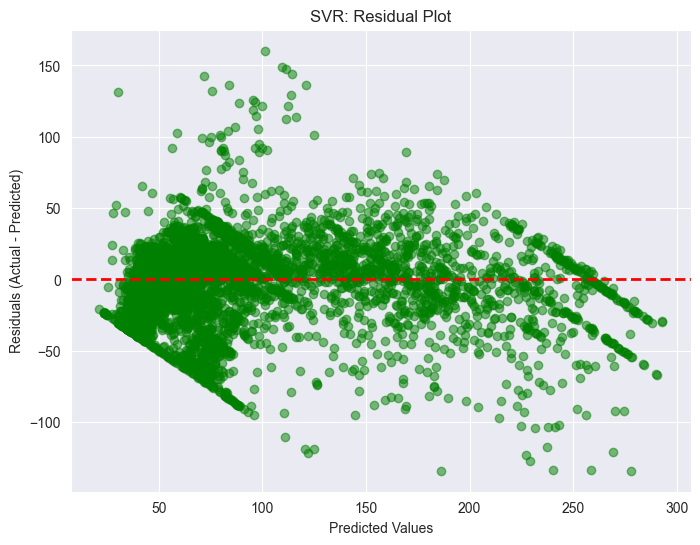

In [25]:
residuals_svr = y_test - y_pred_svr

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_svr, residuals_svr, alpha=0.5, color='green')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('SVR: Residual Plot')
plt.show()


In [34]:
df_full = pd.read_csv("merged_agri_df.csv", parse_dates=["Tarih"])

df_full = preprocess_dataframe(df_full, df_full.columns.difference([target_col, date_col]), target_col)

# Drop unnecessary columns and split the dataset
X = df_full.drop(columns=["Smfdolar", "Tarih"])  # Exclude target and date columns
y = df_full["Smfdolar"]  # Target variable

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (32636, 57), Test shape: (8160, 57)


In [35]:
from sklearn.metrics import mean_squared_error, r2_score  # For evaluating the model

# Initialize the XGBModel object
xgb_model = XGBModel(name="XGBoost", n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)

# Train the model on the training set
xgb_model.fit(X_train, y_train)

# Predict the target variable for the test set
y_pred_xgb = xgb_model.predict(X_test)

# Calculate evaluation metrics
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Print evaluation results
print("XGBModel Evaluation:")
print(f"Mean Squared Error (MSE): {mse_xgb}")
print(f"R² Score: {r2_xgb}")


XGBModel Evaluation:
Mean Squared Error (MSE): 7.969271635884908
R² Score: 0.9975162504486372


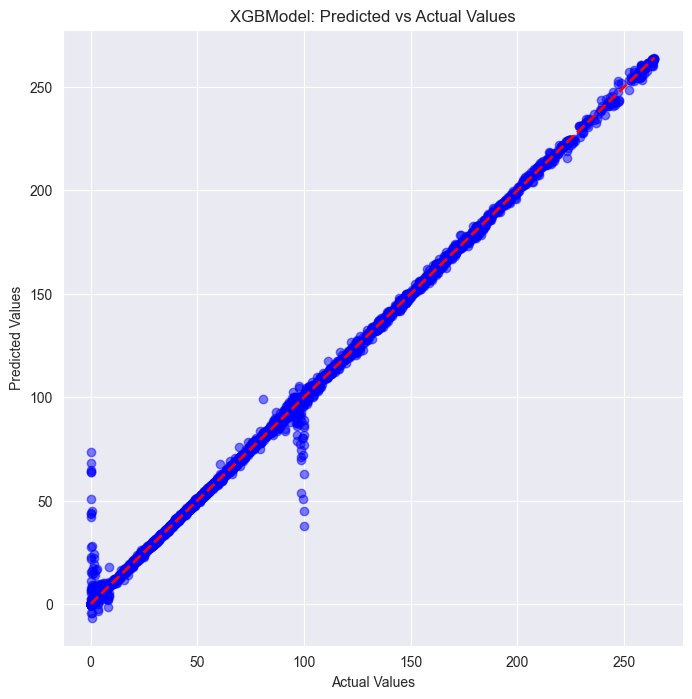

In [36]:
# Predicted vs Actual plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('XGBModel: Predicted vs Actual Values')
plt.show()


# Deep Learning Models

## Imports

In [5]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

from src.models.dl_models import (
    LSTMModel, GRUModel, BiLSTMModel, TransformerModel, TimeSeriesDataset
)

%matplotlib inline

## Data loading & cleaning

In [6]:
df_full = pd.read_csv("merged_agri_df.csv", parse_dates=["Tarih"])

target_col = "Smfdolar"
date_col   = "Tarih"

# 1) Drop rows where target_col is missing
df_full = df_full.dropna(subset=[target_col])

# 2) Replace inf/-inf with NaN
df_full = df_full.replace([np.inf, -np.inf], np.nan)

# 3) Drop any rows that have leftover NaN in numeric columns
numeric_cols = df_full.select_dtypes(include=[np.number]).columns
df_full = df_full.dropna(subset=numeric_cols)

# 4) Let's do a simple scale on numeric columns except the target (you can also scale the target if you want).
scaler = StandardScaler()
all_numeric = df_full.select_dtypes(include=[np.number]).columns.drop(target_col, errors="ignore")

df_full[all_numeric] = scaler.fit_transform(df_full[all_numeric])

# 5) Create X, y from numeric columns
X_df = df_full.drop(columns=[target_col, date_col], errors="ignore").select_dtypes(include=[np.number])
y_df = df_full[target_col].astype(np.float32)

# 6) Train/test split
X_train_arr, X_test_arr, y_train_arr, y_test_arr = train_test_split(
    X_df.values,  # ensures a numeric numpy array
    y_df.values,  # numeric numpy array
    test_size=0.2,
    shuffle=False,
    random_state=42
)

print("Train shape:", X_train_arr.shape, "| Test shape:", X_test_arr.shape)

Train shape: (28218, 55) | Test shape: (7055, 55)


## Common Setup

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

def evaluate_predictions(preds_tensor, y_true_tensor):
    preds = preds_tensor.detach().cpu().numpy().flatten()
    ytrue = y_true_tensor.detach().cpu().numpy().flatten()
    mse = mean_squared_error(ytrue, preds)
    mae = mean_absolute_error(ytrue, preds)
    return mse, mae, preds, ytrue

def plot_results(ytrue_np, ypred_np, title="DL Model"):
    plt.figure(figsize=(10,4))
    plt.plot(ytrue_np, label="Actual", color='blue')
    plt.plot(ypred_np, label="Predicted", color='red')
    plt.title(title)
    plt.legend()
    plt.show()

# Convert to torch tensors, shape => (N,1,F)
X_train_t = torch.tensor(X_train_arr, dtype=torch.float32).unsqueeze(1).to(device)
y_train_t = torch.tensor(y_train_arr, dtype=torch.float32).to(device)

X_test_t  = torch.tensor(X_test_arr,  dtype=torch.float32).unsqueeze(1).to(device)
y_test_t  = torch.tensor(y_test_arr,  dtype=torch.float32).to(device)

Using device: cpu


## LSTM Model


=== LSTM Test ===
Epoch [1/10], Loss: 3487.8972
Epoch [2/10], Loss: 3478.2466
Epoch [3/10], Loss: 3457.0539
Epoch [4/10], Loss: 3413.5914
Epoch [5/10], Loss: 3347.6475
Epoch [6/10], Loss: 3271.6572
Epoch [7/10], Loss: 3195.1745
Epoch [8/10], Loss: 3121.5116
Epoch [9/10], Loss: 3051.2195
Epoch [10/10], Loss: 2984.0689
LSTM => MSE=32211.3594, MAE=168.4965


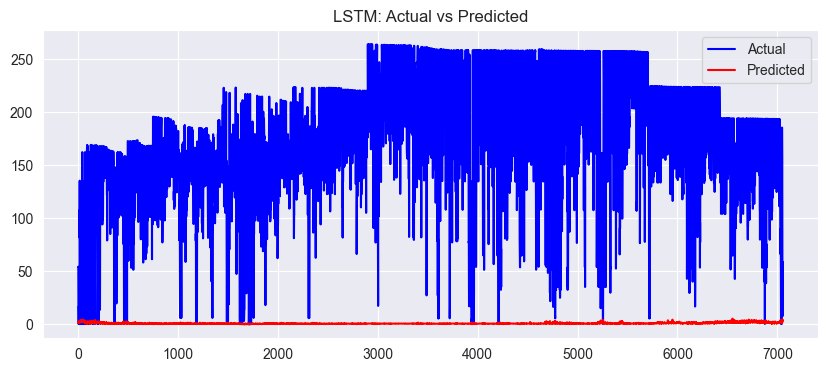

In [12]:
print("\n=== LSTM Test ===")

lstm_model = LSTMModel(
    input_dim=X_train_t.shape[2],
    hidden_dim=64,
    num_layers=2,
    output_dim=1,
    device=device
)

# Lower LR can help avoid "NaN" losses if data is tricky
lstm_model.fit(
    X_train_t,
    y_train_t,
    epochs=10,
    batch_size=32,
    lr=1e-5,   # smaller LR to avoid NaN
    verbose=True
)

y_pred_lstm = lstm_model.predict(X_test_t)
y_pred_lstm = torch.from_numpy(y_pred_lstm).float().to(device)  # convert np->torch for eval

mse_lstm, mae_lstm, preds_np_lstm, ytrue_np = evaluate_predictions(y_pred_lstm, y_test_t)
print(f"LSTM => MSE={mse_lstm:.4f}, MAE={mae_lstm:.4f}")

plot_results(ytrue_np, preds_np_lstm, title="LSTM: Actual vs Predicted")

## GRU Model


=== GRU Test ===
Epoch [1/10], Loss: 3494.3624
Epoch [2/10], Loss: 3468.0367
Epoch [3/10], Loss: 3411.7329
Epoch [4/10], Loss: 3317.3035
Epoch [5/10], Loss: 3205.3189
Epoch [6/10], Loss: 3096.0862
Epoch [7/10], Loss: 2994.3514
Epoch [8/10], Loss: 2899.3585
Epoch [9/10], Loss: 2810.1386
Epoch [10/10], Loss: 2726.2926
GRU => MSE=32806.0273, MAE=170.2437


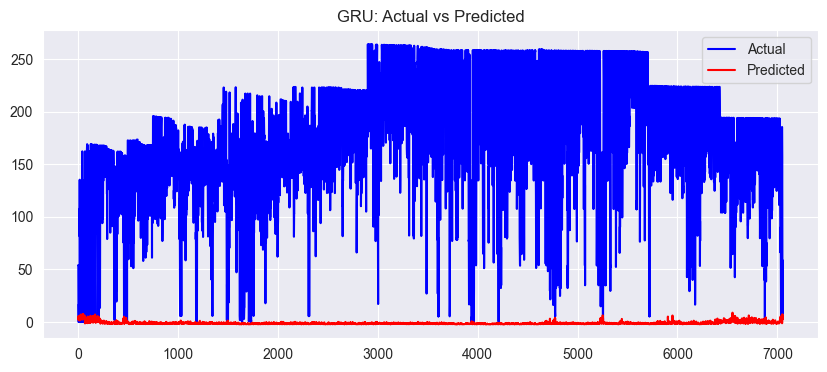

In [13]:
print("\n=== GRU Test ===")

gru_model = GRUModel(
    input_dim=X_train_t.shape[2],
    hidden_dim=64,
    num_layers=2,
    output_dim=1,
    device=device
)

gru_model.fit(
    X_train_t,
    y_train_t,
    epochs=10,
    batch_size=32,
    lr=1e-5,
    verbose=True
)

y_pred_gru = gru_model.predict(X_test_t)
y_pred_gru = torch.from_numpy(y_pred_gru).float().to(device)

mse_gru, mae_gru, preds_np_gru, _ = evaluate_predictions(y_pred_gru, y_test_t)
print(f"GRU => MSE={mse_gru:.4f}, MAE={mae_gru:.4f}")

plot_results(ytrue_np, preds_np_gru, title="GRU: Actual vs Predicted")

## BİLSTM Model


=== BiLSTM Test ===
Epoch [1/10], Loss: 3487.6911
Epoch [2/10], Loss: 3460.6897
Epoch [3/10], Loss: 3373.1910
Epoch [4/10], Loss: 3213.5784
Epoch [5/10], Loss: 3041.9852
Epoch [6/10], Loss: 2885.2041
Epoch [7/10], Loss: 2743.5622
Epoch [8/10], Loss: 2615.1836
Epoch [9/10], Loss: 2498.1073
Epoch [10/10], Loss: 2390.9781
BiLSTM => MSE=31492.7676, MAE=166.4537


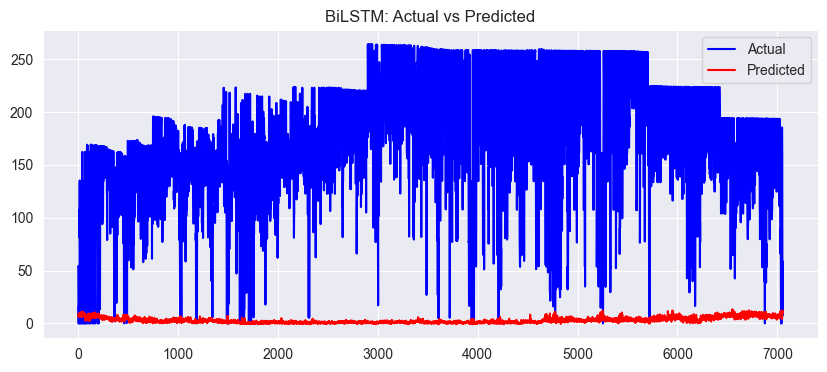

In [14]:
print("\n=== BiLSTM Test ===")

bilstm_model = BiLSTMModel(
    input_dim=X_train_t.shape[2],
    hidden_dim=64,
    num_layers=2,
    output_dim=1,
    device=device
)

bilstm_model.fit(
    X_train_t,
    y_train_t,
    epochs=10,
    batch_size=32,
    lr=1e-5,
    verbose=True
)

y_pred_bilstm = bilstm_model.predict(X_test_t)
y_pred_bilstm = torch.from_numpy(y_pred_bilstm).float().to(device)

mse_bilstm, mae_bilstm, preds_np_bilstm, _ = evaluate_predictions(y_pred_bilstm, y_test_t)
print(f"BiLSTM => MSE={mse_bilstm:.4f}, MAE={mae_bilstm:.4f}")

plot_results(ytrue_np, preds_np_bilstm, title="BiLSTM: Actual vs Predicted")

## Transformer Model


=== Transformer Test ===
Epoch [1/10], Loss: 3128.0483
Epoch [2/10], Loss: 2965.8693
Epoch [3/10], Loss: 2899.8295
Epoch [4/10], Loss: 2835.6215
Epoch [5/10], Loss: 2769.2653
Epoch [6/10], Loss: 2700.4118
Epoch [7/10], Loss: 2630.1387
Epoch [8/10], Loss: 2559.8711
Epoch [9/10], Loss: 2490.0863
Epoch [10/10], Loss: 2420.8386
Transformer => MSE=28466.8613, MAE=157.6174


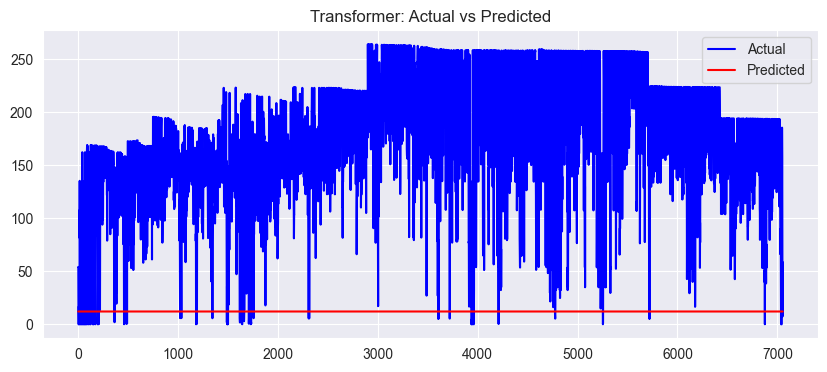

In [15]:
print("\n=== Transformer Test ===")

transformer_model = TransformerModel(
    input_dim=X_train_t.shape[2],
    d_model=64,
    nhead=2,
    num_encoder_layers=1,
    num_decoder_layers=1,
    output_dim=1,
    device=device
)

# For a minimal usage, let's do a "fake" src,tgt => same shape
# In real seq2seq, you'd do something more advanced
src_train = X_train_t
tgt_train = X_train_t
tgt_y_train = y_train_t.unsqueeze(-1).unsqueeze(-1)  # (N,1,1)

transformer_model.fit(
    src_train,
    tgt_train,
    tgt_y_train,
    epochs=10,
    batch_size=32,
    lr=1e-5,
    verbose=True
)

# For test
src_test = X_test_t
tgt_test = X_test_t
pred_transformer = transformer_model.predict(src_test, tgt_test)
pred_transformer_t = torch.from_numpy(pred_transformer).float().to(device).squeeze(-1).squeeze(-1)

mse_trans, mae_trans, preds_np_trans, _ = evaluate_predictions(pred_transformer_t, y_test_t)
print(f"Transformer => MSE={mse_trans:.4f}, MAE={mae_trans:.4f}")

plot_results(ytrue_np, preds_np_trans, title="Transformer: Actual vs Predicted")